Epoch 1/20


c:\Users\haypr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.2074
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0229
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0179
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0172
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0181
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0162
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0159
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0149
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0153
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0151
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0140
Epoch 12/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0149
Epoch 13/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0149
Epoch 14/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0137
Epoch 15/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0142
Epoch 16/20
54/

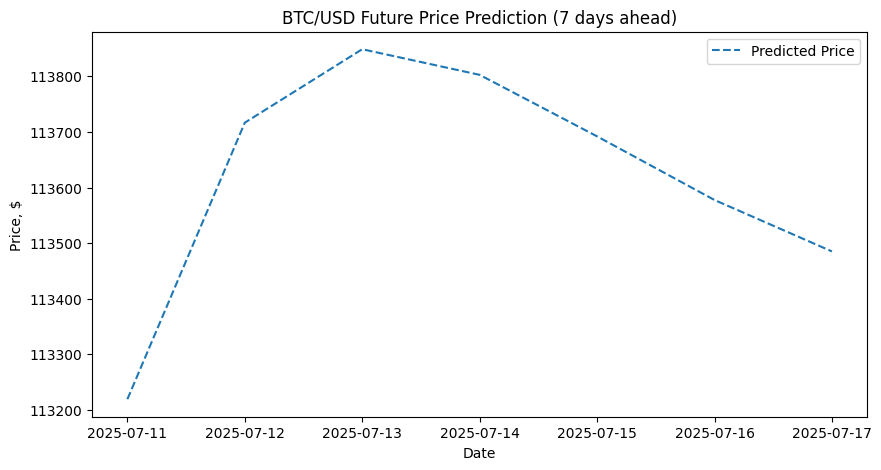

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

coin = 'btc'
big_coin = 'BTC'
time_steps = 120
horizon = 7
target_col = 'close'
symbol = f'BINANCEFTS_PERP_{big_coin}_USDT'

df = pd.read_csv(f"{coin}_ohlcv_full_period.csv", parse_dates=["timestamp"])

df = df.rename(columns={
    "timestamp": "open_time",
    "price_open": "open",
    "price_high": "high",
    "price_low": "low",
    "price_close": "close",
    "volume_traded": "volume"
})
df.set_index(['symbol', 'open_time'], inplace=True)

df_btc = df.xs(symbol, level='symbol').sort_index()

FEATURE_COLS = ['open', 'high', 'low', 'close', 'volume']

def scale_data(df_slice):
    scaler = MinMaxScaler()
    scaled = pd.DataFrame(
        scaler.fit_transform(df_slice[FEATURE_COLS]),
        columns=FEATURE_COLS,
        index=df_slice.index
    )
    return scaled, scaler

def create_sequences(df_sym, feature_cols, time_steps):
    X = []
    values = df_sym[feature_cols].values
    for i in range(len(values) - time_steps + 1):
        X.append(values[i:i + time_steps])
    return np.array(X)

def inv_transform_close(scaler, scaled_vec):
    close_idx = FEATURE_COLS.index(target_col)
    tmp = np.zeros((scaled_vec.shape[0], len(FEATURE_COLS)))
    tmp[:, close_idx] = scaled_vec
    inv = scaler.inverse_transform(tmp)[:, close_idx]
    return inv

# Даты с учетом временной зоны индекса (если tz-aware)
train_end_date = pd.Timestamp('2025-07-10').tz_localize('UTC') if df_btc.index.tz else pd.Timestamp('2025-07-10')
forecast_start_date = train_end_date + pd.Timedelta(days=1)
forecast_end_date = forecast_start_date + pd.Timedelta(days=horizon)

# Обучающие данные: все до 10 июля 2025 включительно
train_data = df_btc.loc[:train_end_date]
if len(train_data) < time_steps:
    raise ValueError("Мало данных для обучения")

train_scaled, scaler = scale_data(train_data)

# Создаём обучающие последовательности для обучения модели
# Так как у нас нет таргета для horizon здесь (прогноз делается после обучения),
# обучаем по окнам time_steps, таргет — следующий шаг (horizon=1)
def create_sequences_for_training(df_sym, feature_cols, time_steps, target_col):
    X, y = [], []
    values = df_sym[feature_cols].values
    target_idx = feature_cols.index(target_col)
    for i in range(len(values) - time_steps):
        X.append(values[i:i+time_steps])
        y.append(values[i+time_steps, target_idx])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences_for_training(train_scaled, FEATURE_COLS, time_steps, target_col)

model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, len(FEATURE_COLS))),
    Dense(1)
])
model.compile(optimizer='adam', loss='mae')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Для прогноза на будущее берем последние time_steps дней перед 11 июля 2025 (forecast_start_date)
last_data_for_pred = df_btc.loc[forecast_start_date - pd.Timedelta(days=time_steps):forecast_start_date - pd.Timedelta(days=1)]

# Масштабируем по обученному scaler
last_data_scaled = pd.DataFrame(
    scaler.transform(last_data_for_pred[FEATURE_COLS]),
    columns=FEATURE_COLS,
    index=last_data_for_pred.index
)

input_seq = last_data_scaled[FEATURE_COLS].values[np.newaxis, :, :]  # shape (1, time_steps, features)

predicted_prices_scaled = []

# Итеративно прогнозируем horizon дней вперёд, каждый раз сдвигая окно
for day in range(horizon):
    pred_scaled = model.predict(input_seq)[0,0]
    predicted_prices_scaled.append(pred_scaled)
    
    # Формируем новое входное окно, сдвигая на 1 день вперед и добавляя предсказанное значение close
    # Для остальных фич просто повторим последний день (можно улучшить при наличии дополнительных предикторов)
    last_step = input_seq[0, -1].copy()
    last_step[FEATURE_COLS.index(target_col)] = pred_scaled
    input_seq = np.append(input_seq[:,1:,:], last_step.reshape(1,1,len(FEATURE_COLS)), axis=1)

# Обратно в реальные цены
predicted_prices = inv_transform_close(scaler, np.array(predicted_prices_scaled))

print(f"\nПрогноз цен {big_coin} на период с {forecast_start_date.date()} по {(forecast_end_date - pd.Timedelta(days=1)).date()} (будущее):")
for i, price in enumerate(predicted_prices, 0):
    print(f"{(forecast_start_date + pd.Timedelta(days=i)).date()}: {price:.2f}")

# График прогноза (без реальных цен, так как это будущее)
plt.figure(figsize=(10,5))
plt.plot(pd.date_range(forecast_start_date, periods=horizon), predicted_prices, label='Predicted Price', linestyle='--')
plt.title(f'{big_coin}/USD Future Price Prediction ({horizon} days ahead)')
plt.xlabel('Date')
plt.ylabel('Price, $')
plt.legend()
plt.show()
